<a href="https://colab.research.google.com/github/ShamsRupak/ai-doc-processing-suite/blob/main/Analyze_a_Scanned_PDF_Revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install pytesseract pdf2image opencv-python
!apt-get install -y poppler-utils tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [12]:
from google.colab import files
uploaded = files.upload()

Saving MTG_10009588.pdf to MTG_10009588 (1).pdf


In [13]:
import cv2
import pytesseract
from pdf2image import convert_from_path
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Convert uploaded PDF to image
pdf_path = list(uploaded.keys())[0]
images = convert_from_path(pdf_path)
image = images[0]
image_np = np.array(image)

In [14]:
# Preprocessing: Grayscale + Noise Reduction + Thresholding
gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)

In [15]:
# OCR with bounding boxes
custom_config = r'--oem 3 --psm 6'
data = pytesseract.image_to_data(thresh, output_type=pytesseract.Output.DICT, config=custom_config)

In [16]:
# Define keywords to extract
key_terms = ["borrower", "lender", "loan", "amount", "property", "address", "date", "recording", "mortgage", "deed", "trust"]

# Extract structured info
structured_output = {}
img_with_boxes = image_np.copy()

for i, word in enumerate(data['text']):
    try:
        conf = float(data['conf'][i])
    except:
        continue  # skip if confidence is not a valid number

    if conf > 60 and word.strip():
        word_clean = word.strip().lower()
        for term in key_terms:
            if term in word_clean:
                bbox = [data['left'][i], data['top'][i], data['width'][i], data['height'][i]]
                structured_output[word] = {
                    "text": word,
                    "bbox": bbox,
                    "confidence": conf
                }
                cv2.rectangle(img_with_boxes, (bbox[0], bbox[1]),
                              (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 2)
                cv2.putText(img_with_boxes, word, (bbox[0], bbox[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

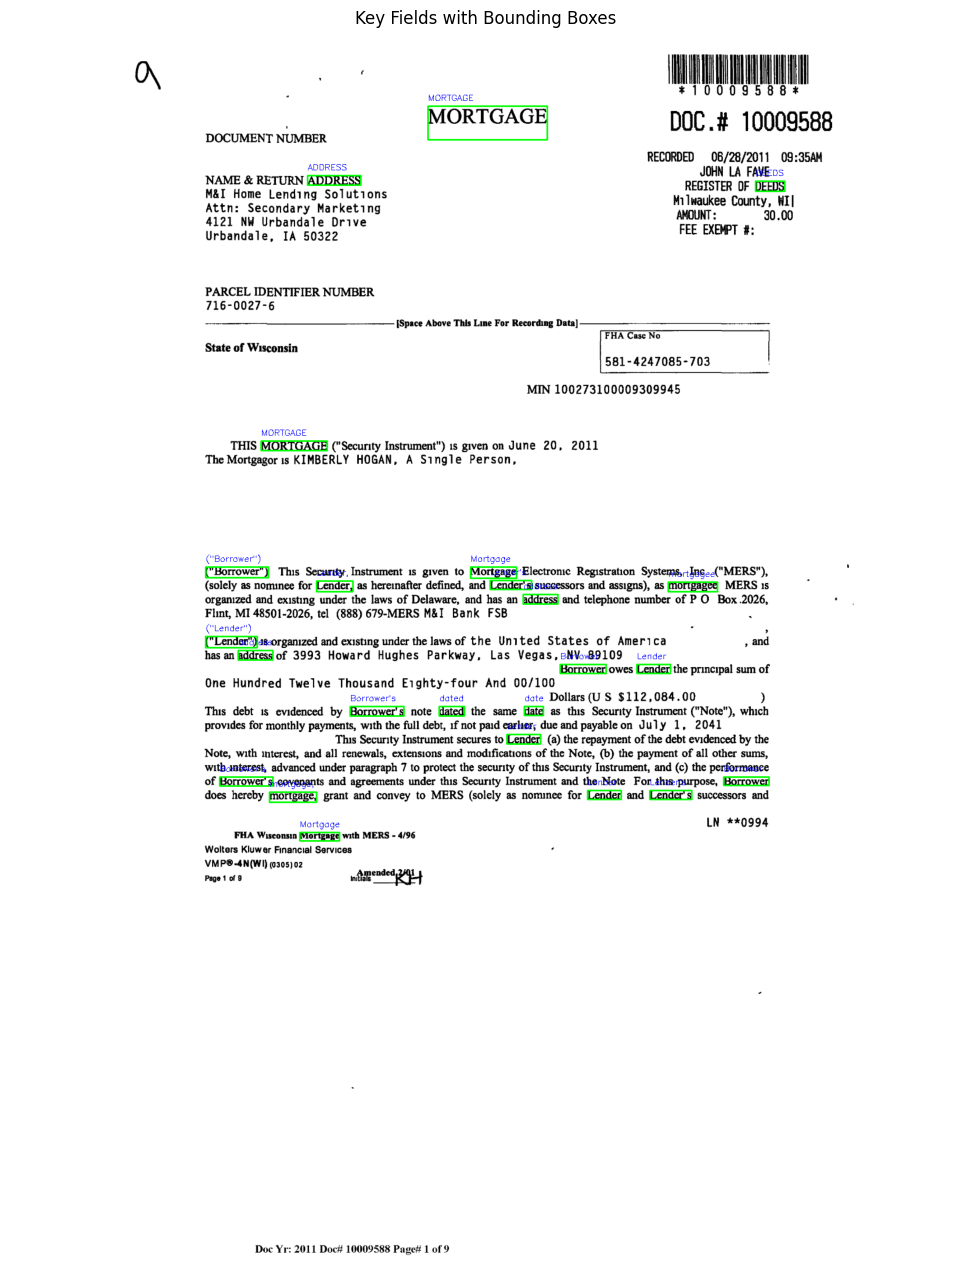

{
  "MORTGAGE": {
    "text": "MORTGAGE",
    "bbox": [
      448,
      730,
      118,
      17
    ],
    "confidence": 96.0
  },
  "ADDRESS": {
    "text": "ADDRESS",
    "bbox": [
      531,
      256,
      95,
      17
    ],
    "confidence": 94.0
  },
  "DEEDS": {
    "text": "DEEDS",
    "bbox": [
      1331,
      266,
      52,
      18
    ],
    "confidence": 87.0
  },
  "(\"Borrower\")": {
    "text": "(\"Borrower\")",
    "bbox": [
      349,
      955,
      112,
      19
    ],
    "confidence": 78.0
  },
  "Mortgage": {
    "text": "Mortgage",
    "bbox": [
      517,
      1429,
      71,
      15
    ],
    "confidence": 96.0
  },
  "Lender,": {
    "text": "Lender,",
    "bbox": [
      547,
      980,
      65,
      19
    ],
    "confidence": 95.0
  },
  "Lender's": {
    "text": "Lender's",
    "bbox": [
      1142,
      1354,
      75,
      16
    ],
    "confidence": 88.0
  },
  "mortgagee": {
    "text": "mortgagee",
    "bbox": [
      1175,
      982,
 

In [17]:
# Show image with bounding boxes
plt.figure(figsize=(16, 16))
plt.imshow(img_with_boxes)
plt.axis('off')
plt.title("Key Fields with Bounding Boxes")
plt.show()

# Show structured JSON output
print(json.dumps(structured_output, indent=2))